In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout



In [30]:
df = pd.read_parquet("data/air-quality-idx.parquet.gzip")
df.head()

/Users/aapo/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/Users/aapo/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/Users/aapo/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,Timestamp,Mannerheimintie,Air pressure (msl) (hPa),Relative humidity (%),Rain intensity (mm/h),Air temperature (degC),Wind direction (deg),Wind speed (m/s)
0,2014-01-01 01:00:00,78.0,1016.8,89.0,0.0,5.1,253.0,4.9
1,2014-01-01 02:00:00,68.0,1016.8,87.0,0.0,5.1,255.0,5.6
2,2014-01-01 03:00:00,60.0,1016.9,85.0,0.0,5.2,246.0,5.3
3,2014-01-01 04:00:00,48.0,1016.9,86.0,0.0,5.2,254.0,5.7
4,2014-01-01 05:00:00,51.0,1017.1,89.0,0.0,5.1,249.0,4.3


In [31]:
df.dtypes

Timestamp                   datetime64[ns]
Mannerheimintie                    float64
Air pressure (msl) (hPa)           float64
Relative humidity (%)              float64
Rain intensity (mm/h)              float64
Air temperature (degC)             float64
Wind direction (deg)               float64
Wind speed (m/s)                   float64
dtype: object

## Baseline model: ARIMA

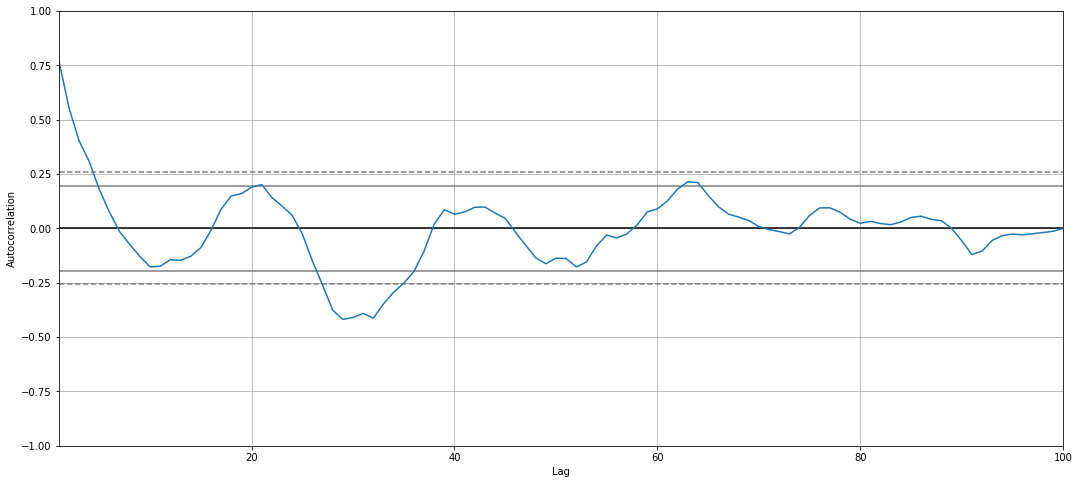

In [32]:
plt.figure(figsize=(18,8))
autocorrelation_plot(df["Mannerheimintie"].iloc[:100])


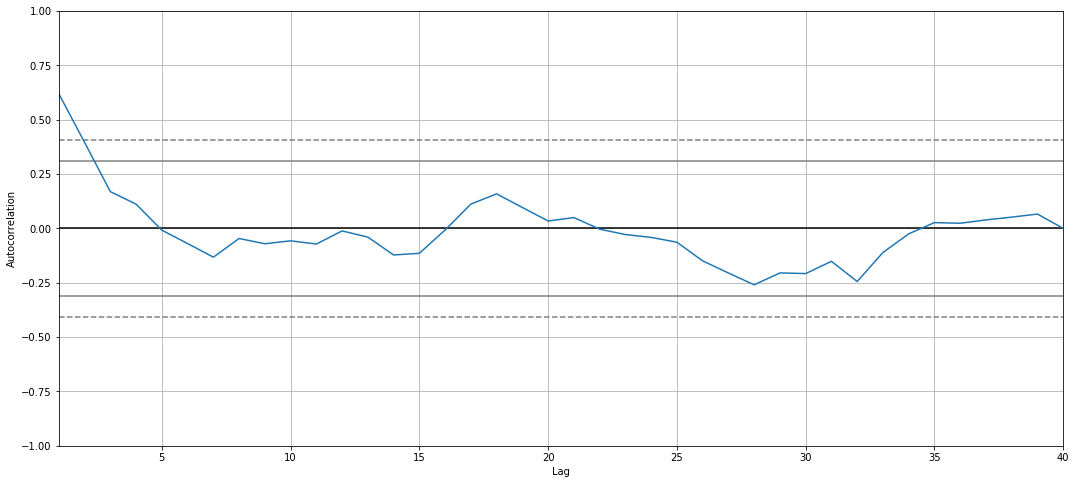

In [33]:
plt.figure(figsize=(18,8))
autocorrelation_plot(df["Mannerheimintie"].iloc[:40])

                             ARIMA Model Results                              
Dep. Variable:      D.Mannerheimintie   No. Observations:                47351
Model:                 ARIMA(3, 1, 0)   Log Likelihood             -176780.582
Method:                       css-mle   S.D. of innovations             10.120
Date:                Tue, 30 Jul 2019   AIC                         353571.163
Time:                        14:26:21   BIC                         353614.990
Sample:                             1   HQIC                        353584.926
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0012      0.032     -0.036      0.971      -0.064       0.062
ar.L1.D.Mannerheimintie    -0.2031      0.005    -44.351      0.000      -0.212      -0.194


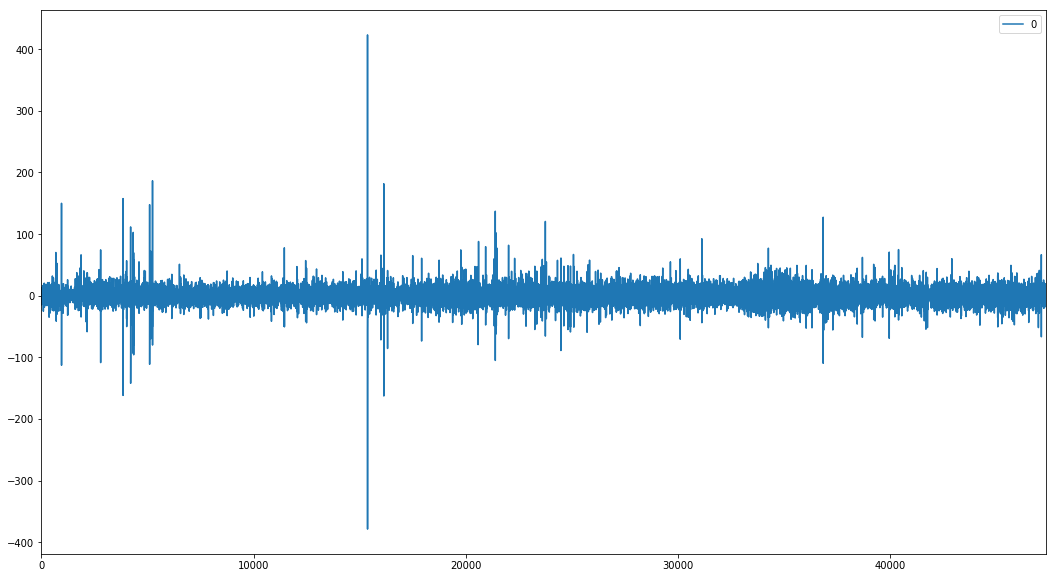

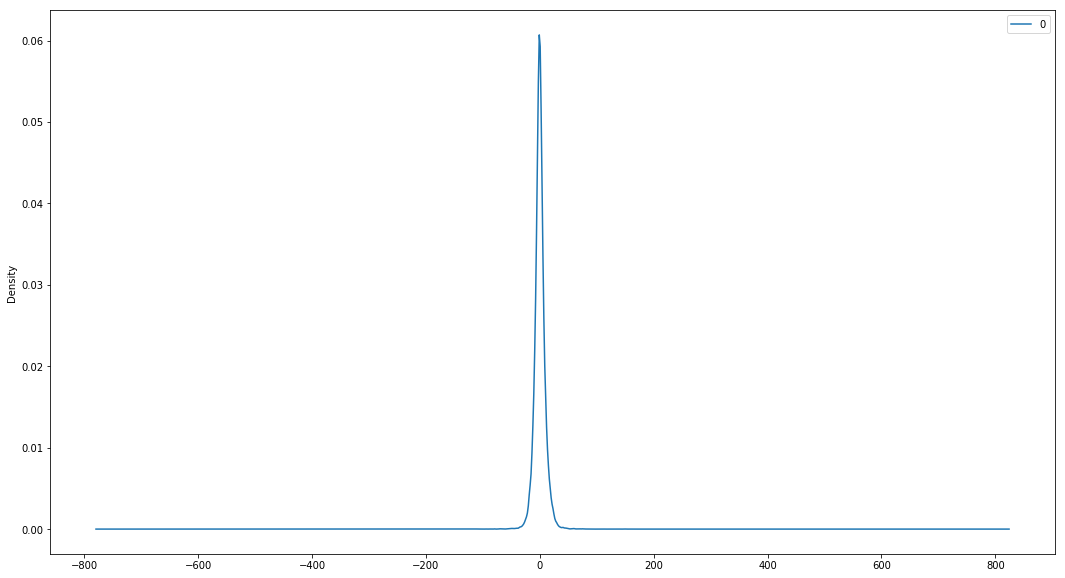

                  0
count  47351.000000
mean      -0.000143
std       10.119655
min     -378.696064
25%       -4.864092
50%       -0.304256
75%        4.471406
max      423.203643


In [34]:
model = ARIMA(df["Mannerheimintie"], order=(3,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(18,10))
plt.show()
residuals.plot(kind='kde', figsize=(18,10))
plt.show()
print(residuals.describe())

Test MSE: 92.138


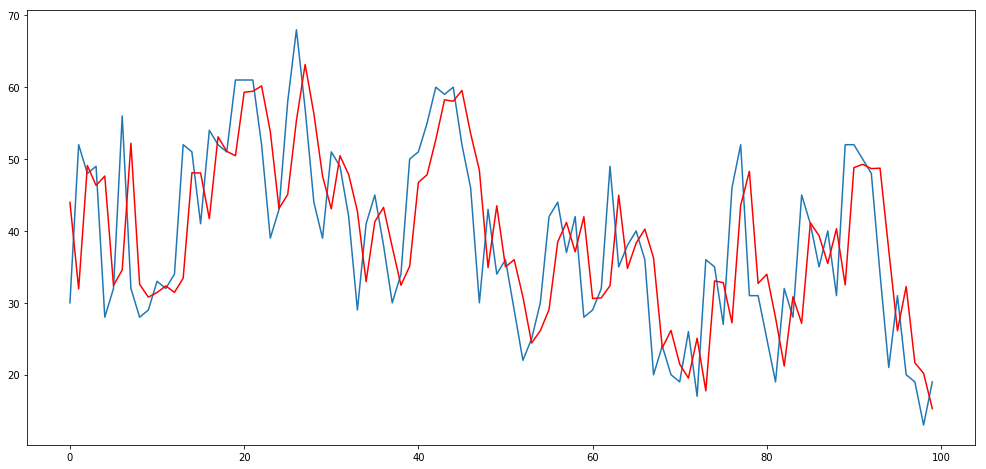

In [35]:
data = df["Mannerheimintie"].values
size = int(len(data) - 100)
train, test = data[0:size], data[size:len(data)]
history = train.tolist()
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(3,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.figure(figsize=(17,8))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Deep learning model: LSTM

In [36]:

n_features = 1
look_back=2
series = df["Mannerheimintie"].values.reshape((len(df["Mannerheimintie"]), n_features))
scaler = RobustScaler()
series = scaler.fit_transform(series)

# split into train and test sets
train_size = int(len(series) - 100)
test_size = len(series) - train_size
train, test = series[0:train_size,:], series[train_size:len(series),:]
train_generator = TimeseriesGenerator(train, train, length=look_back, batch_size=32)
test_generator = TimeseriesGenerator(test, test, length=look_back, batch_size=32)

In [37]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back, n_features), return_sequences=True))
model.add(LSTM(50, activation='relu', dropout=0.3, input_shape=(look_back, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# fit model
model.fit_generator(train_generator, steps_per_epoch=20, epochs=200, verbose=1)

Epoch 1/200
20/20 [==============================] - 3s 126ms/step - loss: 0.6134 - acc: 0.0266
Epoch 2/200
20/20 [==============================] - 0s 6ms/step - loss: 0.5586 - acc: 0.0437
Epoch 3/200
20/20 [==============================] - 0s 6ms/step - loss: 0.3601 - acc: 0.0422
Epoch 4/200
20/20 [==============================] - 0s 6ms/step - loss: 0.4394 - acc: 0.0391
Epoch 5/200
20/20 [==============================] - 0s 6ms/step - loss: 0.2238 - acc: 0.0344
Epoch 6/200
20/20 [==============================] - 0s 5ms/step - loss: 0.2117 - acc: 0.0594
Epoch 7/200
20/20 [==============================] - 0s 5ms/step - loss: 0.2178 - acc: 0.0500
Epoch 8/200
20/20 [==============================] - 0s 5ms/step - loss: 0.2099 - acc: 0.0312
Epoch 9/200
20/20 [==============================] - 0s 6ms/step - loss: 0.1712 - acc: 0.0469
Epoch 10/200
20/20 [==============================] - 0s 6ms/step - loss: 0.2065 - acc: 0.0516
Epoch 11/200
20/20 [==============================] - 0s 

20/20 [==============================] - 0s 6ms/step - loss: 0.2482 - acc: 0.0312
Epoch 88/200
20/20 [==============================] - 0s 6ms/step - loss: 0.1416 - acc: 0.0578
Epoch 89/200
20/20 [==============================] - 0s 6ms/step - loss: 0.3978 - acc: 0.0359
Epoch 90/200
20/20 [==============================] - 0s 5ms/step - loss: 0.1395 - acc: 0.0578
Epoch 91/200
20/20 [==============================] - 0s 5ms/step - loss: 0.1710 - acc: 0.0562
Epoch 92/200
20/20 [==============================] - 0s 8ms/step - loss: 0.1416 - acc: 0.0578
Epoch 93/200
20/20 [==============================] - 0s 6ms/step - loss: 0.1649 - acc: 0.0375
Epoch 94/200
20/20 [==============================] - 0s 6ms/step - loss: 0.1412 - acc: 0.0594
Epoch 95/200
20/20 [==============================] - 0s 5ms/step - loss: 0.2000 - acc: 0.0391
Epoch 96/200
20/20 [==============================] - 0s 5ms/step - loss: 0.9266 - acc: 0.0422
Epoch 97/200
20/20 [==============================] - 0s 5ms/st

20/20 [==============================] - 0s 5ms/step - loss: 0.1432 - acc: 0.0406
Epoch 173/200
20/20 [==============================] - 0s 5ms/step - loss: 0.1678 - acc: 0.0562
Epoch 174/200
20/20 [==============================] - 0s 5ms/step - loss: 0.2163 - acc: 0.0437
Epoch 175/200
20/20 [==============================] - 0s 5ms/step - loss: 0.2751 - acc: 0.0531
Epoch 176/200
20/20 [==============================] - 0s 5ms/step - loss: 0.1397 - acc: 0.0688
Epoch 177/200
20/20 [==============================] - 0s 5ms/step - loss: 0.1526 - acc: 0.0250
Epoch 178/200
20/20 [==============================] - 0s 5ms/step - loss: 0.2047 - acc: 0.0641
Epoch 179/200
20/20 [==============================] - 0s 5ms/step - loss: 0.1916 - acc: 0.0422
Epoch 180/200
20/20 [==============================] - 0s 5ms/step - loss: 0.1363 - acc: 0.0516
Epoch 181/200
20/20 [==============================] - 0s 5ms/step - loss: 0.2471 - acc: 0.0531
Epoch 182/200
20/20 [==============================] -

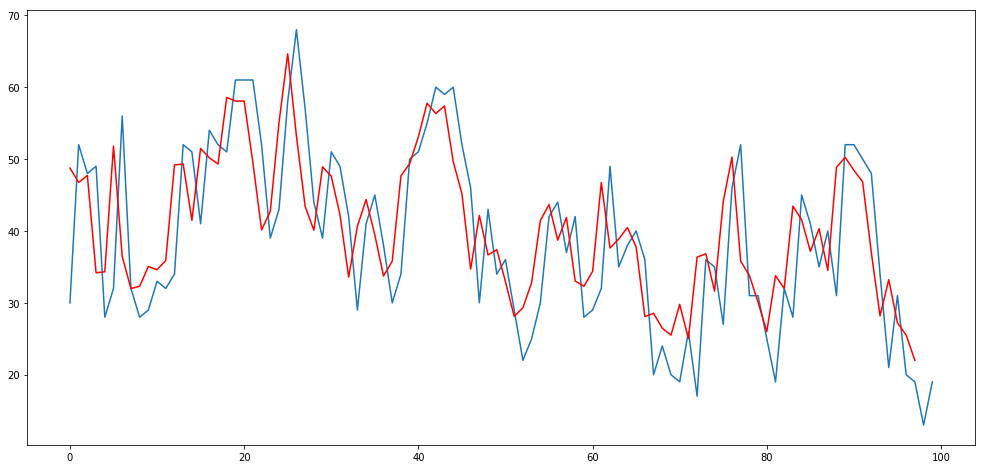

In [38]:
yhat = model.predict_generator(test_generator)
plt.figure(figsize=(17,8))
plt.plot(scaler.inverse_transform(test))
plt.plot(scaler.inverse_transform(yhat), color='red')
plt.show()

In [39]:
test_data = scaler.inverse_transform(test[:len(yhat)])
predictions = scaler.inverse_transform(yhat)

error = mean_squared_error(test_data, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 75.308
